In [1]:
run_all_experiments = True
download_experiments = True

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import spearmanr, kendalltau

In [3]:
def smooth_consecutive_zeros(arr, discount=0.8):
    arr = np.array(arr, dtype=float)
    i = 0
    while i < len(arr):
        if arr[i] == 0:
            start = i
            while i < len(arr) and arr[i] == 0:
                i += 1
            end = i

            prev = next((arr[j] for j in range(start-1, -1, -1) if arr[j] != 0), None)
            next_ = next((arr[j] for j in range(end, len(arr)) if arr[j] != 0), None)

            if prev is not None and next_ is not None:
                base_val = ((prev + next_) / 2) * discount
            elif prev is not None:
                base_val = prev * discount
            elif next_ is not None:
                base_val = next_ * discount
            else:
                base_val = 0  # fallback if all values are 0

            arr[start:end] = base_val
        else:
            i += 1
    return arr.tolist()

# Tests 

In [4]:
gtb = [1,1,1,1,0,1,1,1,0,1]
evb = [1,0,0,1,1,1,1,1,1,1]

# Confusion Matrix
cm = confusion_matrix(gtb, evb)
tn, fp, fn, tp = cm.ravel()

# Metrics
acc = accuracy_score(gtb, evb)
prec = precision_score(gtb, evb)
rec = recall_score(gtb, evb)
f1 = f1_score(gtb, evb)
kend = kendalltau(gtb, evb)[0]
spear = spearmanr(gtb, evb)[0]

# Print nicely
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"Kendall τ: {kend:.3f}")
print(f"Spearman ρ: {spear:.3f}")
print(f"Confusion: TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

Accuracy:  0.600
Precision: 0.750
Recall:    0.750
F1 Score:  0.750
Kendall τ: -0.250
Spearman ρ: -0.250
Confusion: TN: 0, FP: 2, FN: 2, TP: 6


In [5]:
# th = 0.2
# gt = np.array([1,2,3,4,5,4,3,2,1,1])
# mv = np.array([5,4,1,2,1,2,3,4,1,1])
# r1 = generate_uniform_scores(10)
# r2 = generate_regularized_scores(10, repetitions=10)


# ev = r2

# print("gt", gt)
# print("ev", ev)
# print('--------')
# eval2 = ev_test(th, r1, r2, print_scores=True)
# # eval1 = evaluate_trim(th, gt, ev, print_scores=True)

In [6]:
def ev_test(threshold_percent, ground_truth_array, eval_array, print_scores=False):
    # Convert to numpy
    ground_truth_array = np.array(ground_truth_array, dtype=float)
    eval_array = np.array(eval_array, dtype=float)

    # Thresholding for binary classification
    gt_thresh = np.percentile(ground_truth_array, threshold_percent * 100)
    ev_thresh = np.percentile(eval_array, threshold_percent * 100)

    gt_binary = (ground_truth_array >= gt_thresh).astype(int)
    ev_binary = (eval_array >= ev_thresh).astype(int)

    # Metrics
    f1 = f1_score(gt_binary, ev_binary, zero_division=0)
    cosine_sim = cosine_similarity([gt_binary], [ev_binary])[0][0]
    kendall_corr = kendalltau(gt_binary, ev_binary)[0]
    spearman_corr = spearmanr(gt_binary, ev_binary)[0]
    acc = accuracy_score(gt_binary, ev_binary)
    prec = precision_score(gt_binary, ev_binary, zero_division=0)
    rec = recall_score(gt_binary, ev_binary, zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(gt_binary, ev_binary)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = fp = fn = tp = 0

    if print_scores:
        print(f"gt_bin: {gt_binary}")
        print(f"ev_bin: {ev_binary}")
        print(f"Accuracy:      {acc:.3f}")
        print(f"Precision:     {prec:.3f}")
        print(f"Recall:        {rec:.3f}")
        print(f"F1 Score:      {f1:.3f}")
        print(f"Cosine Sim:    {cosine_sim:.3f}")
        print(f"Kendall τ:     {kendall_corr:.3f}")
        print(f"Spearman ρ:    {spearman_corr:.3f}")
        print(f"Confusion:     TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

    return {
        "f1_score": f1,
        "cosine_similarity": cosine_sim,
        "spearman": spearman_corr,
        "kendall": kendall_corr,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "confusion_matrix": {"tn": tn, "fp": fp, "fn": fn, "tp": tp},
        "gt_binary": gt_binary,
        "ev_binary": ev_binary
    }

In [7]:
# Convert timestamps to seconds
def ts_to_s(timestamp):
    h, m, s = timestamp.split(':')
    return int(h) * 3600 + int(m) * 60 + float(s)

def s_to_ts(seconds):
    """
    Extract hours, minutes, seconds, and milliseconds
    from a given number of seconds.
    """

    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = seconds % 60
    milliseconds = int((seconds - int(seconds)) * 1000)

    # Format as HH:MM:SS.MS
    return f"{hours:02}:{minutes:02}:{int(seconds):02}.{milliseconds:03}"

# Convert timestamps to seconds
def timestamp_to_seconds(timestamp):
    h, m, s = timestamp.split(':')
    return int(h) * 3600 + int(m) * 60 + float(s)

In [8]:
def seconds_to_srt_timestamp(seconds):
    """
    Extract hours, minutes, seconds, and milliseconds
    from a given number of seconds.
    """

    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = seconds % 60
    milliseconds = int((seconds - int(seconds)) * 1000)

    # Format as HH:MM:SS,MS
    return f"{hours:02}:{minutes:02}:{int(seconds):02},{milliseconds:03}"

In [9]:
tvsum50_video = "/kaggle/input/tvsum50/tvsum50/video"
tvsum50_anno = "/kaggle/input/tvsum50/tvsum50/data/ydata-tvsum50-anno.tsv"
tvsum50_info = "/kaggle/input/tvsum50/tvsum50/data/ydata-tvsum50-info.tsv"

experiment_results = "/kaggle/input/experiment-6"
# experiment_tag = "_m1w-1.0_m2w-0.3_mdt-0.2_keep"
experiment_tag = "_m1w-1.0_m2w-0.3_mdt-0.2_sentences"

In [10]:
# ['category', 'video_id', 'title', 'url', 'length']
info_df = pd.read_csv(tvsum50_info,sep='\t')

# 0: video_id, 1: category, 2: scores <string of csv scores>
anno_df = pd.read_csv(tvsum50_anno, delimiter='\t', header=None)
anno_df.columns = ['video_id', 'category', 'scores']

# scores array <int array>
anno_df["scores"] = anno_df["scores"].apply(lambda x: np.fromstring(x, sep=',', dtype=int))

In [11]:
def insert_silence_rows(df):
    video_input = video_title
    
    if len(df) < 1:
        return df.copy()

    new_rows = []
    base_idx_counter = 0


    
    # Check for silence at the beginning (if first start_time != "00:00:00.000")
    first_row = df.iloc[0]
    if first_row['start_time'] != "00:00:00.000":
        silence_row = {
            'metric_final': 0.0,
            'start_time': "00:00:00.000",
            'end_time': first_row['start_time'],
            'base_idx': -1,
            'sentence': ''
        }
        new_rows.append(pd.Series(silence_row))



    
    # Process all rows
    for i in range(len(df)):
        # Add current row (with updated base_idx)
        curr_row = df.iloc[i].copy()
        curr_row['base_idx'] = base_idx_counter
        new_rows.append(curr_row)
        base_idx_counter += 1

        # Check for silence between current and next row
        if i < len(df) - 1:
            next_row = df.iloc[i + 1]
            if curr_row['end_time'] != next_row['start_time']:
                silence_row = {
                    'metric_final': 0.0,
                    'start_time': curr_row['end_time'],
                    'end_time': next_row['start_time'],
                    'base_idx': -1,
                    'sentence': ''
                }
                new_rows.append(pd.Series(silence_row))



    
    # Check for silence at the ending (if last start_time < video length)
    video_end_s = get_video_length(video_input)
    video_end_ts = seconds_to_srt_timestamp(video_end_s)

    last_row = df.iloc[-1]
    last_row_seconds = ts_to_s(last_row['end_time'])

    if last_row_seconds < video_end_s:
        print(f'should be in seconds {video_end_s}')
        print(f'appending silence at the end {last_row_seconds} < {video_end_s}')
        silence_row = {
            'metric_final': 0.0,
            'start_time': last_row['end_time'],
            'end_time': video_end_ts,
            'base_idx': -1,
            'sentence': ''
        }
        new_rows.append(pd.Series(silence_row))



    # Group rows into final df
    final_df = pd.DataFrame(new_rows).reset_index(drop=True)
    final_df['base_idx'] = final_df.index  # update base_idx to match row order
    return final_df

In [12]:
# ['metric_final', 'start_time', 'end_time', 'base_idx', 'sentence']
def get_experiment_df(name):
    video_path = os.path.join(experiment_results, name) + experiment_tag +".csv"
    df = pd.read_csv(video_path)
    # return insert_silence_rows(df)
    return df

In [13]:
def get_video_info(name):
    # Load the video
    video = cv2.VideoCapture(f'/kaggle/input/tvsum50/tvsum50/video/{name}.mp4')
    
    # Get the frames per second (FPS)
    fps = video.get(cv2.CAP_PROP_FPS)
    
    # Get the total number of frames in the video
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the video length in seconds
    video_length_sec = frame_count / fps
    
    return (video_length_sec,frame_count,fps)


def get_video_length(name):
    return get_video_info(name)[0]

In [14]:
def plot_experiment_results(video_title, frame_scores, title_prefix="", print_title=False):
    filtered_df = info_df[info_df["video_id"] == video_title]
    if filtered_df.empty:
        raise ValueError(f"Video ID {video_title} not found in info_df")

    title = filtered_df["title"].iloc[0]
    length = filtered_df["length"].iloc[0]
    category = filtered_df["category"].iloc[0]

    plt.close('all')  # Prevent multiple plots
    plt.figure(figsize=(10,5))  # Set figure size before plotting
    plt.plot(frame_scores, label='Score')

    plt.xlabel('Frame Index')
    plt.ylabel('Score')
    
    plot_title = f'{title_prefix} Score Plot for "{title}" [{video_title}] - [{category}] - {length}s'
    plt.title(plot_title)
    
    if print_title:
        print(plot_title)

    plt.legend()
    plt.show()


In [15]:
def generate_single_regularized_score(n, seed=None):
    """
    Generates a list of scores [1-5] of length `n` based on a skewed distribution.

    Distribution:
        - Score 5: 1–5%
        - Score 4: 5–10%
        - Score 3: 10–20%
        - Score 2: 20–40%
        - Score 1: remaining

    Args:
        n (int): Length of score array.
        seed (int, optional): For reproducibility.

    Returns:
        list[int]: List of scores with the specified distribution.
    """
    if seed is not None:
        random.seed(seed)

    # Choose actual percentages randomly within the allowed ranges
    p5 = random.uniform(0.01, 0.05)
    p4 = random.uniform(0.05, 0.10)
    p3 = random.uniform(0.10, 0.20)
    p2 = random.uniform(0.20, 0.40)

    total_assigned = int(p5 * n) + int(p4 * n) + int(p3 * n) + int(p2 * n)
    p1 = n - total_assigned  # Remaining slots for score 1

    scores = (
        [5] * int(p5 * n) +
        [4] * int(p4 * n) +
        [3] * int(p3 * n) +
        [2] * int(p2 * n) +
        [1] * p1
    )

    # Shuffle to randomize order
    random.shuffle(scores)
    return np.array(scores)

def generate_regularized_scores(n, repetitions=20, seed=None):
    """
    Generates an average of 20 lists of scores based on a skewed distribution.

    Args:
        n (int): Length of score array.
        repetitions (int): Number of times to generate and average the scores.
        seed (int, optional): For reproducibility.

    Returns:
        list[float]: List of average scores.
    """
    all_scores = []

    for _ in range(repetitions):
        scores = generate_single_regularized_score(n, seed)
        all_scores.append(scores)

    # Calculate average scores by taking the mean of each position
    avg_scores = [sum(x) / repetitions for x in zip(*all_scores)]
    
    return np.array(avg_scores)

In [16]:
def generate_uniform_scores(n, seed=None):
    """
    Generates a list of `n` random scores between 1.0 and 5.0 with one decimal place.

    Args:
        n (int): Length of the list.
        seed (int, optional): For reproducibility.

    Returns:
        list[float]: List of random scores with one decimal place.
    """
    if seed is not None:
        random.seed(seed)

    uniform_scores = [round(random.uniform(1.0, 5.0), 1) for _ in range(n)]

    return np.array(uniform_scores)

# Experiment Exploration

The 50 videos are grouped by 10 categories (5 videos per category).
The categories are identified by two-letter codes, whose names are:

#### Categories:
- **VT**: Changing Vehicle Tire  
- **VU**: Getting Vehicle Unstuck  
- **GA**: Grooming an Animal  
- **MS**: Making Sandwich  
- **PK**: Parkour  
- **PR**: Parade  
- **FM**: Flash Mob Gathering  
- **BK**: Bee Keeping  
- **BT**: Attempting Bike Tricks  
- **DS**: Dog Show  

In [41]:
videos_of_interest = [
    "0tmA_C6XwfM", #GA
    "98MoyGZKHXc", #VT
    "akI8YFjEmUw", # ?
    "AwmHb44_ouw", # VT
    "Bhxk-O1Y7Ho", # GA
    # "EE-bNr36nyA", # BK
    # "eQu1rNs0an0", # BT
    # "gzDbaEs1Rlg", # VT
    # "Hl-__g2gn_A", # MS
    "jcoYJXDG9sw", # DS
    "JgHubY5Vw3Y", # ?
    "RBCABdttQmI", # PR
    # "Se3oxnaPsz0", # BK
    # "sTEELN-vY30", # VU ?
    "xwqBXPGE9pQ",
    "xxdtq8mxegs",
    # "XzYM3PfTM4w",
    "Yi4Ij2NM7U4"
]

videos_of_interest_df = info_df[info_df["video_id"].isin(videos_of_interest)]

videos_of_interest_df.to_csv(f'/kaggle/working/videos_of_interest.csv', index=False)

display(videos_of_interest_df)

,category,video_id,title,url,length
0,VT,AwmHb44_ouw,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54
1,VT,98MoyGZKHXc,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07
8,VU,xwqBXPGE9pQ,Smart Electric Vehicle Balances on Two Wheels,https://www.youtube.com/watch?v=xwqBXPGE9pQ,3:53
9,VU,akI8YFjEmUw,Electric cars making earth more green,https://www.youtube.com/watch?v=akI8YFjEmUw,2:13
11,GA,Bhxk-O1Y7Ho,Vlog #509 I'M A PUPPY DOG GROOMER! September 1...,https://www.youtube.com/watch?v=Bhxk-O1Y7Ho,7:30
12,GA,0tmA_C6XwfM,Nail clipper Gloria Pets professional grooming,https://www.youtube.com/watch?v=0tmA_C6XwfM,2:21
14,GA,xxdtq8mxegs,How to Clean Your Dog's Ears - Vetoquinol USA,https://www.youtube.com/watch?v=xxdtq8mxegs,2:24
17,MS,Yi4Ij2NM7U4,Poor Man's Meals: Spicy Sausage Sandwich,https://www.youtube.com/watch?v=Yi4Ij2NM7U4,6:45
26,PR,RBCABdttQmI,2013 Alumnae Parade & Laurel Chain Ceremony,https://www.youtube.com/watch?v=RBCABdttQmI,6:04
43,BT,JgHubY5Vw3Y,How to lock your bike. The RIGHT way!,https://www.youtube.com/watch?v=JgHubY5Vw3Y,2:23


## MMVTrim Experiemnt Results: Will a Cat Eat Dog Food ? [-esJrBWj2d8]

In [18]:
video_title = "-esJrBWj2d8" # cat dog food
# video_title = "jcoYJXDG9sw" # obese dog
experiment_df = get_experiment_df(video_title)
experiment_df

,metric_final,start_time,end_time,base_idx,sentence
0,0.128,00:00:00.000,00:00:01.316,0,NaN
1,0.160,00:00:01.316,00:00:01.717,1,Him every.
2,0.132,00:00:01.717,00:00:02.998,2,NaN
3,0.170,00:00:02.998,00:00:03.778,3,Do you know what this is?
4,0.356,00:00:03.778,00:00:05.841,4,NaN
...,...,...,...,...,...
154,0.476,00:03:30.175,00:03:31.008,154,NaN
155,0.640,00:03:31.008,00:03:33.968,155,Then she eats a lot of cat food brands.
156,0.588,00:03:33.968,00:03:42.074,156,NaN
157,0.830,00:03:42.074,00:03:45.138,157,"So yes, cats can eat dog food, yay!"


In [19]:
# Timestamp to Frame conversion

# Preprocessing
experiment_df['start_seconds'] = experiment_df['start_time'].apply(timestamp_to_seconds)
experiment_df['end_seconds'] = experiment_df['end_time'].apply(timestamp_to_seconds)

# # Smoothening
# experiment_df["metric_final"] = smooth_consecutive_zeros(experiment_df["metric_final"].tolist(), discount=0.8)

# Linear Scaling: from 0-1 to 1-5
experiment_df['scaled_metric_final'] = experiment_df['metric_final'] * 4 + 1

experiment_df.head()

,metric_final,start_time,end_time,base_idx,sentence,start_seconds,end_seconds,scaled_metric_final
0,0.128,00:00:00.000,00:00:01.316,0,NaN,0.000,1.316,1.512
1,0.160,00:00:01.316,00:00:01.717,1,Him every.,1.316,1.717,1.640
2,0.132,00:00:01.717,00:00:02.998,2,NaN,1.717,2.998,1.528
3,0.170,00:00:02.998,00:00:03.778,3,Do you know what this is?,2.998,3.778,1.680
4,0.356,00:00:03.778,00:00:05.841,4,NaN,3.778,5.841,2.424


In [20]:
# Map socres to frames
(length_s,n_frames, fps) = get_video_info(video_title)

if fps != 30.0:
    print(f"===== WARN: VIDEO {video_title} is not 30FPS. Was {fps}")

# Initialize array with 1's (lowest score)
frame_scores = np.ones(n_frames)

# Assign scores to frames
for index, row in experiment_df.iterrows():
    start_frame = int(row['start_seconds'] * fps)
    end_frame = int(row['end_seconds'] * fps)
    frame_scores[start_frame:end_frame] = row['scaled_metric_final']

print(frame_scores, '\n')

[1.512 1.512 1.512 ... 3.656 3.656 3.656] 



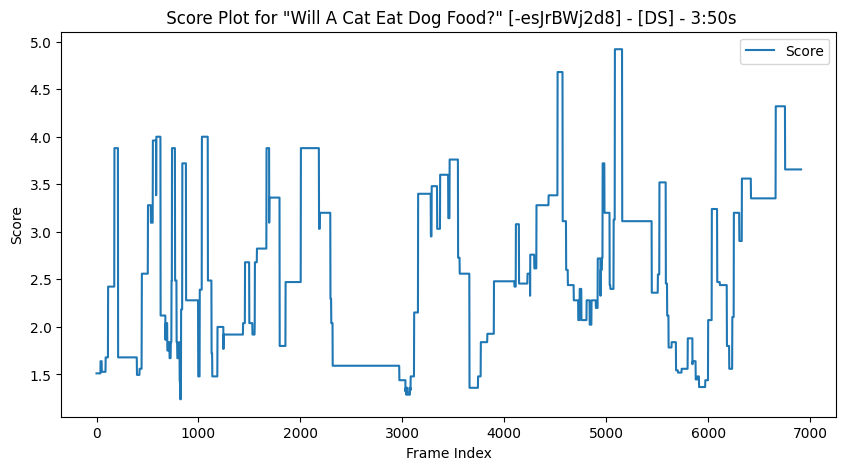

In [21]:
# Plot
plot_experiment_results(video_title, frame_scores)

## Re-run Original Exmple: Will A Cat Eat Dog Food (-esJrBWj2d8)
##### Re-running Experiment to Confirm Consistency

In [22]:
video_title = "-esJrBWj2d8"
i_df = info_df[info_df["video_id"] == video_title]
a_df = anno_df[anno_df["video_id"] == video_title]

display(i_df)
display(a_df.head())

# frame array length
print(f"frame length: {len(a_df.iloc[0]['scores'])}")
print(f"6912/30fps = {6912/30} seconds\n")

# stack values in column into single matrix
scores_matrix = np.stack(a_df["scores"].values) 

# Calculate the average of each index across all rows
cat_food_scores = np.mean(scores_matrix, axis=0)

# Display the averaged scores
print(cat_food_scores)

,category,video_id,title,url,length
49,DS,-esJrBWj2d8,Will A Cat Eat Dog Food?,https://www.youtube.com/watch?v=-esJrBWj2d8,3:50


,video_id,category,scores
980,-esJrBWj2d8,DS,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
981,-esJrBWj2d8,DS,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
982,-esJrBWj2d8,DS,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
983,-esJrBWj2d8,DS,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
984,-esJrBWj2d8,DS,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


frame length: 6912
6912/30fps = 230.4 seconds

[1.95 1.95 1.95 ... 1.5  1.5  1.5 ]


In [23]:
(length_s,n_frames, fps) = get_video_info(video_title)

print(f"FPS: {fps}")
print(f"Video Length: {length_s} seconds")
print(f"Num Frames: {n_frames}")

FPS: 30.0
Video Length: 230.4 seconds
Num Frames: 6912


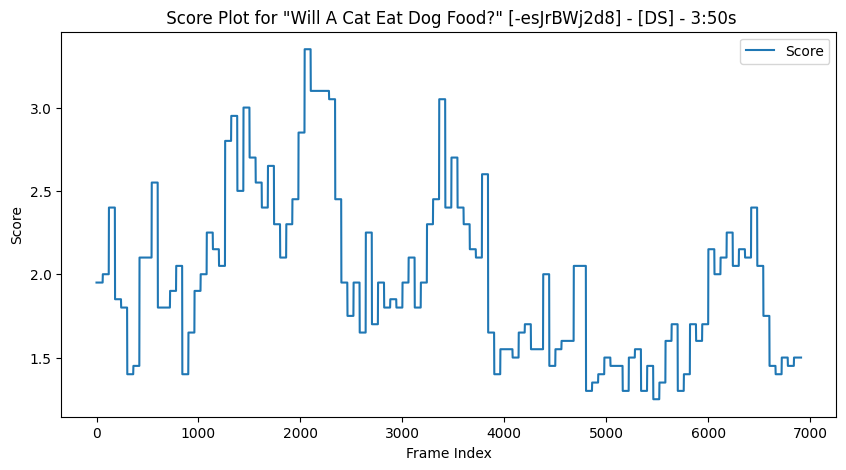

In [24]:
# Plot
plot_experiment_results(video_title, cat_food_scores)

## Question: Scene Consistency: Shouldn't each 60 frame segment share the same score across the 60 frames ?
##### If the experiment is rates 2 second scenes, we should see 2 seconds = 60 frames total having the same score when going frame by frame, for any of the 20 individual scores

In [25]:
n_frames=30

score_1 = a_df.iloc[0]['scores'][1:6901]

reshaped_scores = score_1.reshape(-1, n_frames)
consistent = np.all(reshaped_scores == reshaped_scores[:, 0][:, None], axis=1)
print("All n-frame segments have the same score:", np.all(consistent),'\n')

reshaped_df = pd.DataFrame(reshaped_scores, columns=[f"{i+1}" for i in range(n_frames)])

display(reshaped_df)

All n-frame segments have the same score: True 



,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
226,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
227,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
228,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


#### Index Chosen for consistency: [1:6901] from [0:6912]
#### These are the values leftover:

In [26]:
# Leftover ratings
print(a_df.iloc[0]['scores'][0:1], a_df.iloc[0]['scores'][6901:])

[1] [1 1 1 1 1 1 1 1 1 1 1]


# Multi-Experiment Run

In [27]:
def calc_tvsum_score(video_id):
    return np.mean(
        np.stack(anno_df.loc[anno_df["video_id"] == video_id, "scores"]),
        axis=0
    )

In [28]:
def calc_mmvtrim_score(video_id, fps_warn=False):
    experiment_df = get_experiment_df(video_id)

    # Preprocessing
    experiment_df['start_seconds'] = experiment_df['start_time'].apply(timestamp_to_seconds)
    experiment_df['end_seconds'] = experiment_df['end_time'].apply(timestamp_to_seconds)
    
    # Linear Scaling: from 0-1 to 1-5
    experiment_df['scaled_metric_final'] = experiment_df['metric_final'] * 4 + 1
    
    # Map socres to frames
    (length_s,n_frames, fps) = get_video_info(video_id)
    if fps_warn and fps != 30.0:
        print(f"===== WARN: VIDEO {video_id} is not 30 fps. Was {fps:.4g} fps. Rounding to {round(fps)} fps.")
        fps = round(fps)
    
    # Initialize array with ones
    # frame_scores = np.ones(n_frames)
    frame_scores = np.zeros(n_frames)
    
    # Assign scores to frames
    for index, row in experiment_df.iterrows():
        start_frame = int(row['start_seconds'] * fps)
        end_frame = int(row['end_seconds'] * fps)
        frame_scores[start_frame:end_frame] = row['scaled_metric_final']

    # SMOOTH FRAME SCORES: TEST
    # frame_scores = smooth_consecutive_zeros(frame_scores, discount=0.8)
    
    return frame_scores

In [29]:
def evaluate_trim(threshold_percent, ground_truth_array, eval_array, print_scores=False, debug=""):    

    # Ensure ground_truth_binary is shorter or equal in length
    if len(ground_truth_array) - len(eval_array) == 1:
        ground_truth_array = ground_truth_array[:-1]
    elif len(ground_truth_array) - len(eval_array) == -1:
        eval_array = eval_array[:-1]
    elif len(ground_truth_array) - len(eval_array) != 0:
        print(f"WARN!: Mismatched arrays. of gt:{len(ground_truth_array)}, eval:{len(eval_array)} {debug}")

    ground_truth_binary = binary_thresholder(ground_truth_array, threshold_percent)
    eval_binary = binary_thresholder(eval_array, threshold_percent)
    
    # Cosine Similarity
    cosine_sim = cosine_similarity([ground_truth_binary], [eval_binary])[0][0]
    
    # Confusion Matrix and Metrics
    cm = confusion_matrix(ground_truth_binary, eval_binary)
    if cm.size == 4:  # Ensure the confusion matrix has 4 values (TN, FP, FN, TP)
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = fp = fn = tp = 0  # Handle the case where the confusion matrix is not full
    
    accuracy = accuracy_score(ground_truth_binary, eval_binary)
    precision = precision_score(ground_truth_binary, eval_binary, zero_division=0)
    recall = recall_score(ground_truth_binary, eval_binary, zero_division=0)
    f1 = f1_score(ground_truth_binary, eval_binary, zero_division=0)

    # Kendalls & Spearmans Rank Correlation
    kendall_corr, _ = kendalltau(ground_truth_array, eval_array)
    spearman_corr, _ = spearmanr(ground_truth_array, eval_array)

    # AUC/ROC
    if len(np.unique(ground_truth_binary)) == 1 or len(np.unique(eval_binary)) == 1:
        auc_roc = 0    
    else:
        auc_roc = roc_auc_score(ground_truth_binary, eval_binary)
    
    # Return all metrics as a dictionary
    metrics = {
        "trim": threshold_percent,
        "cosine_similarity": cosine_sim,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "kendall": kendall_corr,
        "spearman": spearman_corr,
        "auc_roc": auc_roc,
        "confusion_matrix": {
            "true_negative": tn,
            "false_positive": fp,
            "false_negative": fn,
            "true_positive": tp
        }
    }

    if print_scores:
        print("Trim %:", threshold_percent, '\n')
        print("Cosine Similarity:", cosine_sim, '\n')
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall, '\n')
        print("F1-Score:", f1, '\n')

        print("Kendall", kendall_corr)
        print("Spearman", spearman_corr)
        print("AUC/ROC", auc_roc)

    return metrics

In [30]:
def top_k_binary(array, trim_percent):
    k = int(len(array) * (1 - trim_percent))
    top_k_indices = np.argsort(array)[-k:]
    binary = np.zeros_like(array, dtype=int)
    binary[top_k_indices] = 1
    return binary

def percentile_binary(array, trim_percent):
    if trim_percent == 0:
        return np.ones_like(array, dtype=int)
    elif trim_percent == 1:
        return np.zeros_like(array, dtype=int)
        
    threshold = np.percentile(array, trim_percent * 100)
    return (array >= threshold).astype(int)

def binary_thresholder(array, trim_percent):
    return percentile_binary(array, trim_percent)    

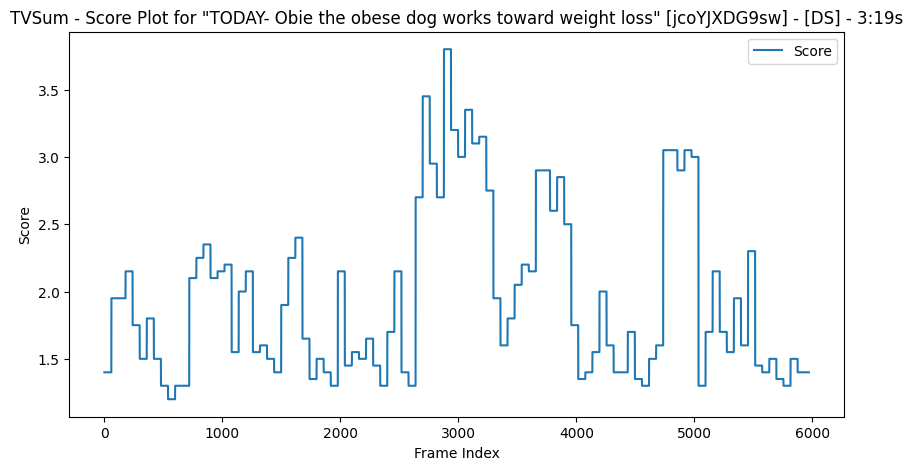

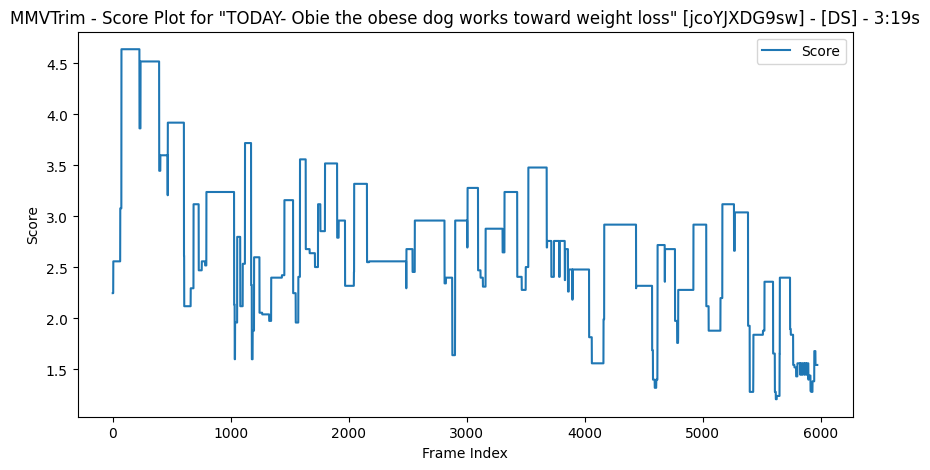

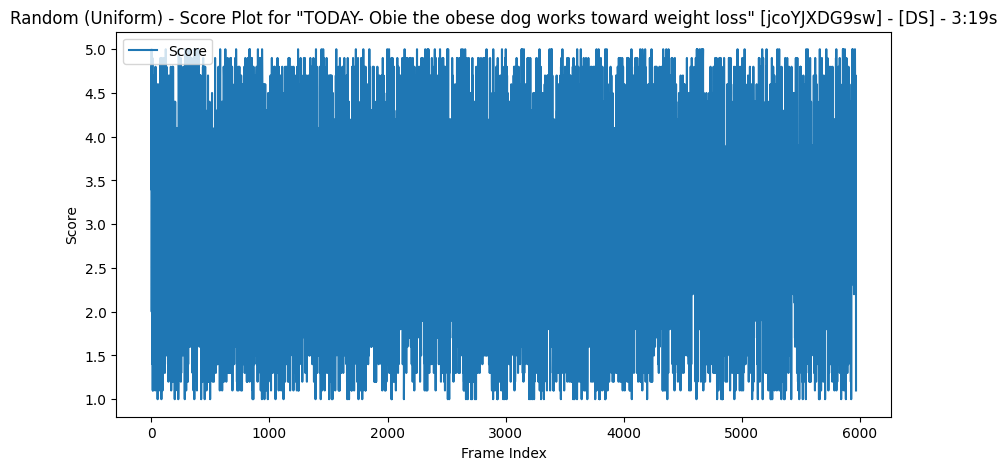

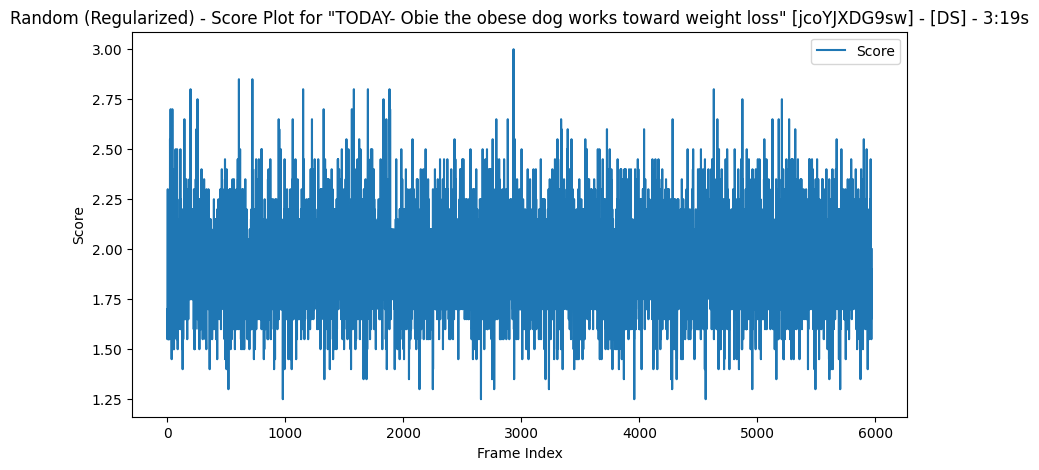

In [31]:
# video_id = "-esJrBWj2d8" # cat dog food
video_id = "jcoYJXDG9sw" # obese dog
# video_id = "Se3oxnaPsz0" # news, eradicate bees
# video_id = "0tmA_C6XwfM" # dog nail grooming

# TVSum Scores
tvsum_scores = calc_tvsum_score(video_id)
score_length = len(tvsum_scores)

# MMVTrim Scores
mmvtrim_scores = calc_mmvtrim_score(video_id)

# Random Regularized
random_regularized_scores = generate_regularized_scores(score_length)

# Random Uniform
random_uniform_scores = generate_uniform_scores(score_length)

# plot
plot_experiment_results(video_id, tvsum_scores, title_prefix="TVSum -", print_title=False)
plot_experiment_results(video_id, mmvtrim_scores, title_prefix="MMVTrim -")

plot_experiment_results(video_id, random_uniform_scores, title_prefix="Random (Uniform) -")
plot_experiment_results(video_id, random_regularized_scores, title_prefix="Random (Regularized) -")

## F1-Score Evaluation: Single Threshold

In [32]:
threshold_percent = 0.3
ground_truth_array = tvsum_scores
eval_array = mmvtrim_scores
# eval_array = random_uniform_scores
# eval_array = random_regularized_scores

print_scores = True

# Ensure ground_truth_binary is shorter or equal in length
if len(ground_truth_array) - len(eval_array) == 1:
    ground_truth_array = ground_truth_array[:-1]
elif len(ground_truth_array) - len(eval_array) == -1:
    eval_array = eval_array[:-1]

ground_truth_binary = binary_thresholder(ground_truth_array, threshold_percent)
eval_binary = binary_thresholder(eval_array, threshold_percent)

print(f"bin unique:{np.unique(ground_truth_binary)}, eval unique: {np.unique(eval_binary)}")

# print("ground truth original", ground_truth_array)
# print("ground truth binary: ", ground_truth_binary)
# print("ground truth threshold: ", ground_truth_threshold)

# print("\neval array original: ", eval_array)
# print("eval array binary:   ", eval_binary)
# print("eval array threshold: ", eval_threshold)

# Cosine Similarity
cosine_sim = cosine_similarity([ground_truth_binary], [eval_binary])[0][0]

# Confusion Matrix and Metrics
cm = confusion_matrix(ground_truth_binary, eval_binary)
if cm.size == 4:  # Ensure the confusion matrix has 4 values (TN, FP, FN, TP)
    tn, fp, fn, tp = cm.ravel()
else:
    tn = fp = fn = tp = 0  # Handle the case where the confusion matrix is not full

accuracy = accuracy_score(ground_truth_binary, eval_binary)
precision = precision_score(ground_truth_binary, eval_binary, zero_division=0)
recall = recall_score(ground_truth_binary, eval_binary, zero_division=0)
f1 = f1_score(ground_truth_binary, eval_binary, zero_division=0)

# Kendalls & Spearmans Rank Correlation
kendall_corr, _ = kendalltau(ground_truth_array, eval_array)
spearman_corr, _ = spearmanr(ground_truth_array, eval_array)

# AUC/ROC
if len(np.unique(ground_truth_binary)) == 1 or len(np.unique(eval_binary)) == 1:
    print(f"bin unique:{np.unique(ground_truth_binary)}, eval unique: {np.unique(eval_binary)}")
    auc_roc = 0    
else:
    auc_roc = roc_auc_score(ground_truth_binary, eval_binary)
    
# Return all metrics as a dictionary
metrics = {
    "trim": threshold_percent,
    "cosine_similarity": cosine_sim,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "kendall": kendall_corr,
    "spearman": spearman_corr,
    "auc_roc": auc_roc,
    "confusion_matrix": {
        "true_negative": tn,
        "false_positive": fp,
        "false_negative": fn,
        "true_positive": tp
    }
}

if print_scores:
    print("\nTrim %:", threshold_percent, '\n')
    print("Cosine Similarity:", cosine_sim, '\n')
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall, '\n')
    print("F1-Score:", f1, '\n')
    print("Kendall:", kendall_corr)
    print("Spearman:", spearman_corr)
    print("AUC/ROC:", auc_roc)

bin unique:[0 1], eval unique: [0 1]

Trim %: 0.3 

Cosine Similarity: 0.7899548526114419 

Accuracy: 0.6918439122425054
Precision: 0.7890535917901939
Recall: 0.7908571428571428 

F1-Score: 0.7899543378995433 

Kendall: 0.10211907778035541
Spearman: 0.14872570277284863
AUC/ROC: 0.6056416040100251


## F1 Graph at all Thresholds

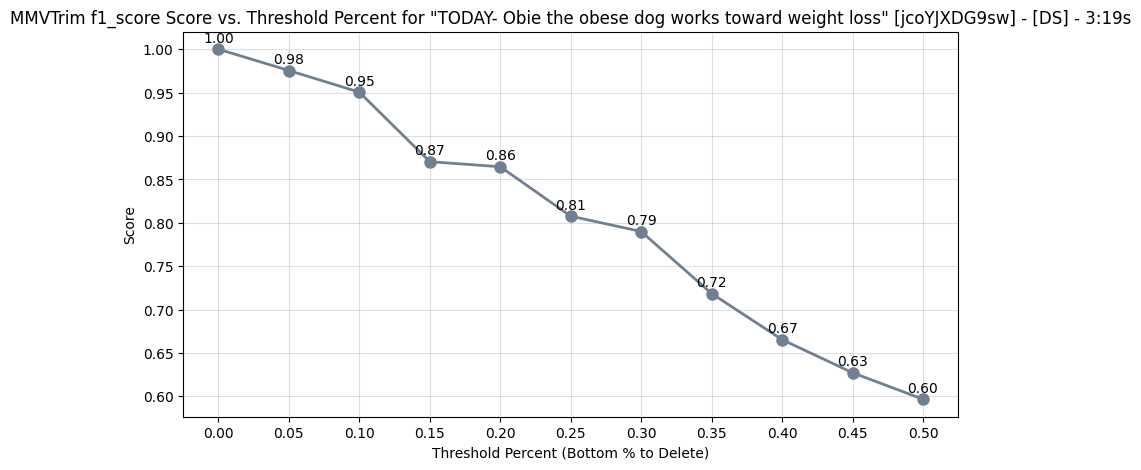

In [33]:
metric_key = "f1_score"
eval_array = mmvtrim_scores
# eval_array = random_uniform_scores
# eval_array = random_regularized_scores


# range of threshold_percent values
threshold_percent_values = np.arange(0, 0.55, 0.05)  # From 0.05 to 0.5 in steps of 0.05

# Initialize a list to store metric scores
metric_scores = []

# Loop through each threshold_percent value
for threshold_percent in threshold_percent_values:
    # Evaluate the function

    # MMVTrim
    trim_eval = evaluate_trim(threshold_percent, tvsum_scores, eval_array, print_scores=False)
    
    # Append the F1 score to the list
    metric_scores.append(trim_eval[metric_key])

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(threshold_percent_values, metric_scores, marker='o', linestyle='-', color='#708090', markersize=8, linewidth=2)

# Title
filtered_df = info_df[info_df["video_id"] == video_id]
if filtered_df.empty:
    raise ValueError(f"Video ID {video_id} not found in info_df")
title = filtered_df["title"].iloc[0]
length = filtered_df["length"].iloc[0]
category = filtered_df["category"].iloc[0]
plot_title = f'MMVTrim {metric_key} Score vs. Threshold Percent for "{title}" [{video_id}] - [{category}] - {length}s'
# plot_title = f'Random F1 Score (Regularized) vs. Threshold Percent'
plt.title(plot_title)

# Adding labels to each dot
for i, score in enumerate(metric_scores):
    plt.annotate(f'{score:.2f}', (threshold_percent_values[i], metric_scores[i]),
                 textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10)

plt.xlabel("Threshold Percent (Bottom % to Delete)")
plt.ylabel("Score")
plt.grid(True, linestyle='-', alpha=0.4)
plt.xticks(threshold_percent_values)
plt.show()

# Graph 2.0 Against Random

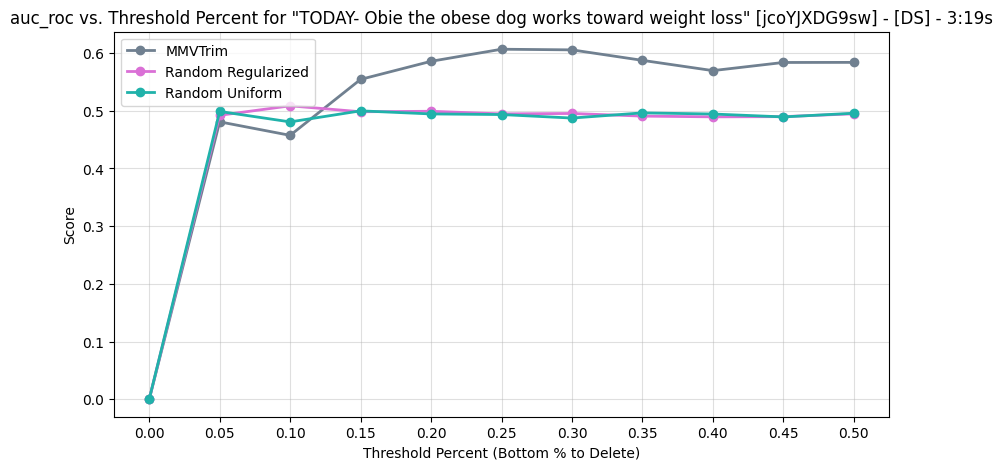

In [34]:
metric_key = "auc_roc"

threshold_percent_values = np.arange(0, 0.55, 0.05)

metrics = {
        "trim": threshold_percent,
        "cosine_similarity": cosine_sim,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "kendall": kendall_corr,
        "spearman": spearman_corr,
        "auc_roc": auc_roc,
        "confusion_matrix": {
            "true_negative": tn,
            "false_positive": fp,
            "false_negative": fn,
            "true_positive": tp
        }
    }

score_series = {
    "MMVTrim": mmvtrim_scores,
    "Random Regularized": random_regularized_scores,
    "Random Uniform": random_uniform_scores
}

f1_results = {}

for label, pred_scores in score_series.items():
    f1_results[label] = [
        evaluate_trim(thresh, tvsum_scores, pred_scores, print_scores=False)[metric_key]
        for thresh in threshold_percent_values
    ]

# Plot
plt.figure(figsize=(10, 5))
colors = ['#708090', '#DA70D6', '#20B2AA']

for i, (label, f1s) in enumerate(f1_results.items()):
    plt.plot(threshold_percent_values, f1s, label=label, marker='o', linewidth=2, color=colors[i])

# Title
filtered_df = info_df[info_df["video_id"] == video_id]
title = filtered_df["title"].iloc[0]
length = filtered_df["length"].iloc[0]
category = filtered_df["category"].iloc[0]
plot_title = f'{metric_key} vs. Threshold Percent for "{title}" [{video_id}] - [{category}] - {length}s'
plt.title(plot_title)

plt.xlabel("Threshold Percent (Bottom % to Delete)")
plt.ylabel("Score")
plt.grid(True, linestyle='-', alpha=0.4)
plt.xticks(threshold_percent_values)
plt.legend()
plt.show()

# All Experiments

In [44]:
if run_all_experiments:
    exp_all_metric = "auc_roc"

    run_videos_of_interest = False
    experiment_batch = videos_of_interest_df if run_videos_of_interest else info_df
    
    # Experiments Df
    f1_columns = np.round(np.arange(0, 0.55, 0.05), 2).tolist()
    columns = [
        "video_id", 
        "title", 
        "category", 
        "url",
        "length",
        "video_of_interest"
    ] + f1_columns
    experiments_all_df = pd.DataFrame(columns=columns)
    
    for _, experiment in experiment_batch.iterrows():
        experiment_data = {
            "video_id": experiment["video_id"],
            "title": experiment["title"],
            "category": experiment["category"],
            "url": experiment["url"],
            "length": experiment["length"],
            "video_of_interest": experiment["video_id"] in videos_of_interest
        }
        
        # Scores for TVSum/MMVtrim
        tvsum_scores_i = calc_tvsum_score(experiment["video_id"])
        mmvtrim_scores_i = calc_mmvtrim_score(experiment["video_id"])
    
        # F1 Columns Init
        for trim_threshold_percent in f1_columns:
            experiment_data[trim_threshold_percent] = None
                
        for trim_threshold_percent in f1_columns:
            scores = evaluate_trim(trim_threshold_percent, tvsum_scores_i, mmvtrim_scores_i, debug=experiment_data['video_id'])
            experiment_data[trim_threshold_percent] = scores[exp_all_metric]
    
        experiments_all_df.loc[len(experiments_all_df)] = experiment_data
    
    experiments_all_df.head()

# Average Scores for Entire Dataset

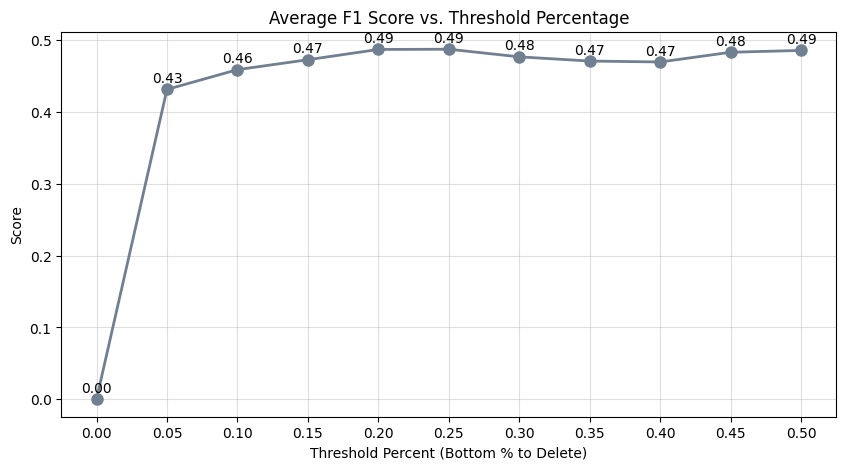

In [45]:
if run_all_experiments:
    f1_columns = np.round(np.arange(0, 0.55, 0.05), 2).tolist()
    
    f1_scores = np.mean(
        np.stack(experiments_all_df.loc[:, f1_columns].values),
        axis=0
    )
    
    # range of threshold_percent values
    threshold_percent_values = np.arange(0, 0.55, 0.05)  # From 0.05 to 0.5 in steps of 0.05
    
    
    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(threshold_percent_values, f1_scores, marker='o', linestyle='-', color='#708090', markersize=8, linewidth=2)    
    plt.title(f'Average F1 Score vs. Threshold Percentage')
    
    # Adding labels to each dot
    for i, score in enumerate(f1_scores):
        plt.annotate(f'{score:.2f}', (threshold_percent_values[i], f1_scores[i]),
                     textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10)
    
    plt.xlabel("Threshold Percent (Bottom % to Delete)")
    plt.ylabel("Score")
    plt.grid(True, linestyle='-', alpha=0.4)
    plt.xticks(threshold_percent_values)
    plt.show()

### Download

In [37]:
# Download
if download_experiments:
    df_to_print = experiments_all_df
    filename = f'/kaggle/working/experiments_all.csv'
    
    df_to_print.to_csv(filename, index=False)
    
    # # Display the link for downloading
    # import os
    # from IPython.display import FileLink
    
    # # Provide a downloadable link
    # FileLink(filename)